# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [126]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# NB my_measures is a .py module that will not import unless in same folder as this ipynb file
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [66]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [131]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    ## how can you posit 'my_random_seed' before it's been defined in another cell?
    ## what does 'fn' mean?  A variable that will later hold the wiki training/test data?
    ## process_raw_data is a function.  reason nothing printed at the end of this cell is because you didn't call the function, only defined it.
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    ## pd.read_csv is pandas for reading csv data.  Wouldn't run correctly if you don't import pandas first (1st cell)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    ## what does .head attribute give?
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        ## is this printing rate or total count?
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, stop_words='english', alternate_sign=False)
        ## HashingVectorizer does similar task as CountVectorizer, converts text docs into matrix entries, except it gives sparse matrix--more computationally efficient for large datasets
        ## what does n_features=2 ** 17 mean?  '**' is math operator, so no. of features = 35?  Nope, 2 ** 20 refers to "roughly one million possible features" (https://scikit-learn.org/stable/modules/feature_extraction.html)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
        
    if (not test):
        chv = HashingVectorizer(alternate_sign=False, analyzer='char_wb', ngram_range=(2,4))
        X_chv = chv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(chv)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)
    else:
        X_chv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)

# the performance of features is not necess related to the sum or cumulative aggregation of features, as adding ngrams and char ngrams do not appear to result in better performance together
        
#     if (not test):
#         ccv = CountVectorizer(stop_words='english', ngram_range=(2,3))
#         X_ccv = ccv.fit_transform(toxic_data.comment_text)
#         fitted_transformations.append(ccv)
#         print("Shape of CountVectorizer n_gram X:")
#         print(X_ccv.shape)
#     else:
#         X_ccv = fitted_transformations[0].transform(toxic_data.comment_text)
#         print("Shape of CountVectorizer n_gram X:")
#         print(X_ccv.shape)
    
    X_cv = hstack([X_hv, X_chv])
    print("Shape of Vectorizer combined X:")
    print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
#     toxic_data['punc_count_exc'] = toxic_data['comment_text'].str.count("\!")
#     toxic_data['punc_count_q'] = toxic_data['comment_text'].str.count("\?")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = X_tfidf
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [132]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_train.csv', my_random_seed=36)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [133]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("False Positive Rate:")
print(ols_performance_train.performance_measures['FP'] / ols_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_train.performance_measures['TP'] / ols_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 6378, 'TN': 58071, 'FP': 56634, 'FN': 6573, 'Accuracy': 0.5048646362098139, 'Precision': 0.10121881546372119, 'Recall': 0.492471623812833, 'desc': 'ols_train'}
False Positive Rate:
0.49373610566235127
True Positive Rate:
0.492471623812833


### MODEL: SVM, linear

In [134]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)
print("False Positive Rate:")
print(svm_performance_train.performance_measures['FP'] / svm_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_train.performance_measures['TP'] / svm_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12935, 'TN': 114682, 'FP': 23, 'FN': 16, 'Accuracy': 0.9996944914457605, 'Precision': 0.9982250347275814, 'Recall': 0.9987645741641572, 'desc': 'svm_train'}
False Positive Rate:
0.0002005143629309969
True Positive Rate:
0.9987645741641572


### MODEL: logistic regression

In [135]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)
print("False Positive Rate:")
print(lgs_performance_train.performance_measures['FP'] / lgs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_train.performance_measures['TP'] / lgs_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12933, 'TN': 114681, 'FP': 24, 'FN': 18, 'Accuracy': 0.999670990787742, 'Precision': 0.998147719379486, 'Recall': 0.9986101459346769, 'desc': 'lgs_train'}
False Positive Rate:
0.00020923237871060547
True Positive Rate:
0.9986101459346769


### MODEL: Naive Bayes

In [136]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)
print("False Positive Rate:")
print(nbs_performance_train.performance_measures['FP'] / nbs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_train.performance_measures['TP'] / nbs_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12790, 'TN': 105978, 'FP': 8727, 'FN': 161, 'Accuracy': 0.9303753838440809, 'Precision': 0.5944137193846726, 'Recall': 0.9875685275268319, 'desc': 'nbs_train'}
False Positive Rate:
0.07608212370864391
True Positive Rate:
0.9875685275268319


### MODEL: Perceptron

In [137]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)
print("False Positive Rate:")
print(prc_performance_train.performance_measures['FP'] / prc_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_train.performance_measures['TP'] / prc_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12918, 'TN': 114686, 'FP': 19, 'FN': 33, 'Accuracy': 0.9995926552610139, 'Precision': 0.9985313442065393, 'Recall': 0.9974519342135743, 'desc': 'prc_train'}
False Positive Rate:
0.00016564229981256266
True Positive Rate:
0.9974519342135743


### MODEL: Ridge Regression Classifier

In [ ]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

### MODEL: Random Forest Classifier

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

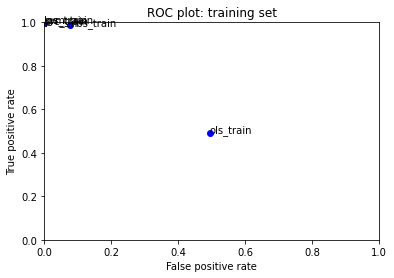

In [138]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [83]:
ols_predictions = ols.predict(X_train)

In [84]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
86
I can't see any answar to your act? Comanche cph
* * * * * * * * * 
101
, 6 January 2014 (UTC)
Support, glad to see this proposal resurrected and glad to see the community's support for it.    11:17
* * * * * * * * * 
203
The language of the source does not matter.  You can add it in the same as any other source.  One of the additional parameters you can use is; | language =  So add that to the source with the language name.   fan
* * * * * * * * * 
204
Children? 

He had quite a lot of children. Any record of where they ended up? 109.154.9.232
* * * * * * * * * 
235
Hey are you kidding me.... I was adding info to this site.. to make it much more reliable. You must be sick headed to think I am removing things. No body ever dared to care about this article... It was me, who are trying to give some life.. yo useriously must be out of your mind... go right ahead and do as you wish.. I was jsut helping... and there is no more need of maintenance tags,.. all 

1645
This is written by a duo on the disco night 7/9/12. We rock and we gonna show that we can dance woo!!!!!!!!! Ohh... and this pic is cool.
* * * * * * * * * 
1655
"

 reference needed for the paragraph you added 

You added something about ""shannon's formula"" (sic) in the Double-slit_experiment article.  Please give a citation or link to take the reader to substantiation for this claim.   "
* * * * * * * * * 
1664
Thanks for your note. Can you back that up with any references? I'm told the revival of the word in Amercian English comes (obviously) from North American editors and I'm wondering what is special about it and why we should have it. Thanks.
* * * * * * * * * 
1716
Frankly, this article should be deleted (not rewritten). You may want to consider the limit of 0.999... in an article on limits. I don't think it belomngs to the Positional System either. All positional systems are based on approximations.
* * * * * * * * * 
1718
Comment 

If its not too churlish, I think ther

3251
Protected edit request on 24 April 2014 

Until the dispute is resolved, please change the page to March 31 (https://en.wikipedia.org/w/index.php?title=Olivet_University&diff;=602140597&oldid;=597402640) before the start of the content dispute / edit war.
* * * * * * * * * 
3428
Deadkid dk
Has been a nusence to wikipedia, i respect your decision to not block him, but please do not tell me I am in the wrong for reporting his abuse...Thank you sir.
* * * * * * * * * 
3464
somebody please Wikify.  I picked up just the fact on Ogura from a book on mathematicians.
* * * * * * * * * 
3573
I am wiling to talk.  But all my opponents do is revert.  06:30, 31 Mar 2005 (UTC)
* * * * * * * * * 
3579
"a liberal person's article that has personal blog criticism, and yet you haven't removed any of the criticism. There is clearly a quality difference between Media Matters analysis and Moorewatch.com, but nonetheless you seem fixated on one. Why is that?  

I am looking at an article that used to 

5140
Please 

Escape this place while you can. Don't end up like me. Having nightmares about this place. I keep on thinking it will completely go away, but it doesn't.
* * * * * * * * * 
5191
"
 Your submission at Articles for creation 
Your nomination at Articles for Creation was declined, and Wikipedia talk:Articles for creation/Leon Rolyat was not created. Please view your submission to see the comments left by the reviewer, and please feel free to request article creation again once the issues have been addressed. Thank you for your contributions to Wikipedia!  - EdoDodo talk "
* * * * * * * * * 
5239
"== CVUA ==

 '''[[User_Talk:Theopolisme|polisme]] ''' 

Hi Zeeyanketu, welcome to the CVUA! I will be your instructor and hope that you'll have a really great experience, and learn along the way. I have created an academy page specifically for you, located at  (talk • contributions) 

 RE 

ETT
So you will decide what is the best format? Don't boss around.  

Top Most respected criti

6954
"

Orphaned non-free image (Image:Dekofisanime.jpg)
Thanks for uploading Image:Dekofisanime.jpg. The image description page currently specifies that the image is non-free and may only be used on Wikipedia under a claim of fair use. However, the image is currently orphaned, meaning that it is not used in any articles on Wikipedia. If the image was previously in an article, please go to the article and see why it was removed. You may add it back if you think that that will be useful. However, please note that images for which a replacement could be created are not acceptable for use on Wikipedia (see our policy for non-free media).

If you have uploaded other unlicensed media, please check whether they're used in any articles or not. You can find a list of 'image' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any non-free im

8557
Bongwarrior 

userpage needs protection from me.
* * * * * * * * * 
8683
Not surprising given D Miliband wants the UK law changed to allow Israeli war criminals to enter the country with impunity.   
 And more on the Israeli War criminals and Miliband here... http://news.bbc.co.uk/1/hi/8415161.stm You can see where his loyalties lie.
* * * * * * * * * 
8743
I think Sandy is capable enough of defending herself on her own, and does not need wiki-lawyers going aroung sending warnings. If she wants to warn Wikidea about what she perceives as a misconduct, or if she wants to point out possible infringements of Wiki-policies by Wikidea or any other user, she can do it herself, as she has already done it once in the FAR in question. Any other non-asked interventions like the one I read above are not helpful at all.
* * * * * * * * * 
8791
Okay, that's enough. Three tries at this  one of which came after I explained to you about getting yourself a free copy of MediaWiki  plus the Appley E

10977
Foreign heads of state and government 

I assume visiting foreign heads of state rank immediately after the president.  What about visiting foreign heads of government?  Can anyone find any sources on this?
* * * * * * * * * 
10987
", 3 July 2009 (UTC)

The very first French ""Open"" was won by a British, one did NOT have to be a French national. 17:52"
* * * * * * * * * 
11039
It would be great if you could re-include / re-incorporate The Tyndale Society on the William Tyndale page, as you suggest above.  I notice that there is already a Society website link on David Daniell's page - thanks for the note about this, so I hope you might be able to use the same link? By the way, we've also put a link to the William Tyndale Wikipedia page on our membership blog (http://thetyndalesociety.blogspot.com/) to encourage newcomers to Tyndale to use this page as a reference source.
* * * * * * * * * 
11061
Three different editors have reverted your external link. Stop now, or be blocked.
* 

12759
I have not even logged into Wikipedia. why the you are mailing me and notifying this crap?
This is the limit, stop hounding me.
* * * * * * * * * 
12813
"

:The Drawbridge newspaper
A tag has been placed on The Drawbridge newspaper, requesting that it be speedily deleted from Wikipedia. This has been done under the criteria for speedy deletion, because the article seems to be blatant advertising that only promotes a company, product, group, service or person and would need to be fundamentally rewritten in order to become an encyclopedia article. Please read the general criteria for speedy deletion, particularly item 11, as well as the guidelines on spam. 

If you can indicate why the subject of this article is not blatant advertising, you may contest the tagging. To do this, please add  on the top of The Drawbridge newspaper and leave a note on the article's talk page explaining your position. Please do not remove the speedy deletion tag yourself, but don't hesitate to add inform

14451
"ADHD stands for Adrians Dumbass Has Disorders (it can also work with other ""A"" starting names is a fun way to see ADHD""
"
* * * * * * * * * 
14471
Only if you want to find a reason to block me which I want to believe that you don't, it can not be what you assume, because since we had our agreement I am only using only one account, please see carefully the edits must be quite different.Dodona
* * * * * * * * * 
14493
2013 (UTC)
Are we talking about the same people? I'm not seeing anyone who has raised a fuss over this getting in trouble over it.   15:34, 6 April
* * * * * * * * * 
14551
??
I Was Mearly Asking You A Question
* * * * * * * * * 
14590
"

Yes, it sounds to me that way. it may sound different to you. That is exactly why it is original research, performed by you and me.  What up? "
* * * * * * * * * 
14601
hello gfoley4 

i have 6 foot man in my basement
* * * * * * * * * 
14625
Angelo: the item you reverted was itself a revert of previous vandalism.  Your revert re

16125
You stick to your talk page, I'll d mine, right?   20:
* * * * * * * * * 
16191
"
Note also probable block evasion as  雲‍水 "
* * * * * * * * * 
16194
"| decline=To be honest, I fail to see how any of this addresses any of the evidence that led to the sockpuppetry block: similar areas of interest, similar username, similar grammar/style, and this (which was probably not the best idea). Free advice: insulting the blocking administrator doesn't really achieve anything.  t/c "
* * * * * * * * * 
16307
Please provide a reference... didn't I already say that?  Read up on how to reference and provide an English-language reference.
* * * * * * * * * 
16311
Yeap its sad and wrong but scholars are getting involved now.We all know that wikipedia its not the place to get ur info but reading the books and articles.The truth will find here way!
* * * * * * * * * 
16363
LanguageXpert and user:Kmrhistory  
LanguageXpert and user:Kmrhistory are probably one person therefore this and this category

17871
Funny!  I think the slowness may be due to both the end of year holidays and recent indef of someone.
* * * * * * * * * 
17883
OER inquiry 
Hi , I'm sending you this message because you're one of about 300 users who have recently edited an article in the umbrella category of open educational resources (OER) (or open education). In evaluating several projects we've been working on (e.g. the WIKISOO course and WikiProject Open), my colleague  and I have wondered who chooses to edit OER-related articles and why. Regardless of whether you've taken the WIKISOO course yourself - and/or never even heard the term OER before - we'd be extremely grateful for your participation in this [https://docs.google.com/forms/d/1Xc5vpYN1EH6cWlMnuJKSofKgCrWjEQ4amyPTxPhRqzg/viewform brief, anonymous survey] before 27 April. No personal data is being collected. If you have any ideas or questions, please get in touch. My talk page awaits. Thanks for your support! -
* * * * * * * * * 
17890
At least give 

19611
"

  Southofwatford: The claim that everything that appears in a newspaper is a sourced fact is just absurd. The word ""fact"" in such a context no longer has any useful meaning because every rumour or piece of speculation that gets reported has to be treated as factual information. So if newspaper 1 reports something that is directly contradicted by newspaper 2 then both are reporting ""facts"" - the mind boggles! My complaint is that you are imposing changes on everyone else involved without any discussion of them and then defending them simply by saying you have a source. Of course we could all do this, but you know as well as I do that the result would be a chaotic mess - more or less what we are getting with this article. It was made clear when protection was turned down that the discussion page was to be used before making changes - you only like to discuss after the event because you know your changes are going to be challenged. Given that your methodology means working by

21468
There is a portrait of Phillip IV hunting, but the dog doesn't appear to be sniffing his crotch as it is in the image of Don Fernando de Austria.
* * * * * * * * * 
21482
hidey_ho  hidey_hole  hidey_hoe  
Please, do you know anything about  hidey?

Thank You,

[[ hopiakuta  Please do  sign  your  signature  on your  message.  %7e%7e   Thank You. -]]
* * * * * * * * * 
21487
Is that a problem? i doubt anyone would reply to that and i am replying to clear confusions further readers may have.
* * * * * * * * * 
21510
I love this book sooooooooooooooooooooo much
* * * * * * * * * 
21543
"::I am very surprised that ""Jack"" is still eliminating verified sources and inserting his own editorializing into the ""sexuality"" section while it is under active discussion here.  As the material I have restored to the section makes clear, this is not just a matter of three critics examining Rydberg's poems, nor is it sensationalizing.  While it would be inappropriate to examine the specific det

23510
And you are not biased about the JP article?? Bwahahaha.  What does Aiken stating anything have to do with the veracity of events?  What I know is that you DID make those statements in your blog, and now you are saying that you did NOT. All of which is beside the point.  We will just work towards getting the article deleted and then you do not have to worry about it any more.
* * * * * * * * * 
23697
Requested move 

Atanarjuat →  – This is the title in the English-speaking world. WP:EN
* * * * * * * * * 
23704
Thanks, Seav. I'll send out the questions via email this week (first week of April, 2006) and it would be great to have your answers back by this coming weekend. —
* * * * * * * * * 
23735
As you will see below, I have formally nominated the article for deletion. Please state your case in the discussion there and others will respond. In general, we have tried to use registration as the bar for notability for political parties. In some cases such as Palmer United, this has 

25280
"

Based on the discussions there, it looks like the page needs a copy-edit ""to clean up the prose"" before it's peer-reviewed again re GA renomination. It'd take about 3 hours, at most. Tomorrow afternoon (EST) okay? I'll bang it out right after the OWS section. I'd be happy to work with a collaborator, if you've got others in mind.   "
* * * * * * * * * 
25351
":I think the definition is fine (though it could be generalized a bit).

Forwarding is the process of actually sending data. It depends on routing, but routing can occur without forwarding.

Routing does not depend on having an aggregatable address.  For example, prefixes blocks on the Internet today are becoming less aggregatable.  This is a problem for BGP's scalability, but it doesn't make BGP less of a routing protocol.  In fact, there exist routing protocols which need no concept of an address at all, such as ROFL , distributed hash tables, many ad hoc routing protocols like DSDV, and various proposals in a researc

29479
I've just done a quick search using Google and the only English sources I can see for the claim are Twitter feeds, Wordpress-type blogs and Facebook pages, none of which are reliable sources. However, Google does not always index Indian newspapers particularly well - perhaps you can find something that I have missed? -
* * * * * * * * * 
29512
"  The one that I just kicked off the article page is a picture from ""Combat and Survival"" magazine (unreliable source as far as I care) that looked a lot like an advertisement for Blackhawk.  The picture you provided earlier is of a chubby, bearded guy wearing of all things a multicam baseball cap with a smiley face patch on it.  Give me a break here.  Reliable sources, believable and substantive pictures showing substantive (beyond baseball caps and mag pouches) usage."
* * * * * * * * * 
29521
thats a spicy meat-a-ball
* * * * * * * * * 
29544
My edits are based on 'published reliable sources'. I will re-edit the articles and supply re

31324
Eh, alright.  Although examples are helpful in understanding the stuff.  I realized soon after posting my example that the impact force from a large collision isn't well distributed throughout (it's mainly in the front where it hits) and can get very complex, so it wouldn't be a good example. 130.184.250.29
* * * * * * * * * 
31402
Please stop advertising and reverting to your ad.  This is not the place for that.
* * * * * * * * * 
31604
Semi-protected edit request on 26 Jpoouly 2014 

49.203.160.215
* * * * * * * * * 
31654
"

ANI Thread
There is an ANI Thread concerning you, please go there to comment. -  • Talk • "
* * * * * * * * * 
31682
Saskatchewan Party 

If you read the citations on the material that was removed, you will see that it is merely an editorial from an individual who does not have, nor claims to have first-hand knowledge of the incident in question.  This type of source, which just amounts to rumour and innuendo, is not appropriate to include in Wikipedia, an

32909
Thank you! That's very kind of you, particularly because you do, too. D Perfect picture.  (talk)
* * * * * * * * * 
32941
The Duke Of B's presentation (right) has some with pattens worn. or there's a print in 1460s commons cat with pattens alongside. I'm sure there are others.
* * * * * * * * * 
33024
Please stop. If you continue to vandalize Wikipedia, as you did to Nero, you will be blocked from editing.   (Talk) 
If this is a shared IP address, and you didn't make any unconstructive edits, consider creating an account for yourself so you can avoid further irrelevant warnings.
* * * * * * * * * 
33032
"

Please tell me where the ""personal attack"" in my post was, and please explain why no action was taken to the person who insulted me"
* * * * * * * * * 
33062
, 6 February 2012 (UTC)

It seems that even the two main instigators have come around to realizing their mistake in the NONPROFIT issue, as they have now taken to editing the article and snipping out entire parts that co

34350
Body forces, of which gravity is an important one, are not included in the presented form of the Euler equations.
* * * * * * * * * 
34416
. And if this is were his real objective, he could even have included the Dutch colonies in the 17th century, as there were New Amsterdam (aka New York) and in Bresil (Recife, Olinda).
* * * * * * * * * 
34467
"

Arabic form: الملك or ملك
I may easily be mistaken, but shouldn't the Arabic form given in parentheses be simply ""ملك"", without the definite article (-ال)?  When so prefixed, as the article itself indicates, it refers exclusively to God (""the King""), not the more general, ""human"" concept.  Or at least that's my understanding.   "
* * * * * * * * * 
34496
"

Followup
I figured it out. The actual code needs to be this:

{{{1}}}

  "
* * * * * * * * * 
34561
"::::::::I won't edit war with a troll, but I do feel this needs to be seen .    (talk) 
"
* * * * * * * * * 
34629
Is Shego Disturbed? 

I think it would be pretty cool to exp

36183
, 9 April 2010 (UTC)

 And no, we do not all accept that random users who have sought or accepted the power should be able to override other users edits, this case being a good example of why. My non-cooperation with wiki beauracracy is deliberate, conscious, and a matter of conscience. The expected behaviour in wiki no matter what the worth of the material added is to incorporate what of it we can, not to wholesale revert. Your attitude is as much in question as my own, Mr V.    13:34
* * * * * * * * * 
36255
"

 Chart and [eaks 

I edited the name of the ""Charts"" section to ""Charts and peaks."" This was reverted a couple of times. My argument on naming the section as such is that the old title does not describe it well. It is not only a list of charts... it also shows the peaks. I wanted to post this up here to see who would argue or disagree to in my opinion a better tittle.    "
* * * * * * * * * 
36301
Of course I'm the same. Why else would I be writing on Edgar's talk pa

38015
"

No, #2 is the correct meaning. #1 is nonsense, as it is vacuously satisfied for any statement in any theory: one of the two algorithms ""return YES"" and ""return NO"" always works. I do not see any ambiguity in the formulation, it clearly starts with an existential quantifier, and in any case, there is a link to decidability (logic) which explains it in detail. You just have to read carefully. —  J. "
* * * * * * * * * 
38089
My plan worked
Ha, ha! My plan to get my brother, User:JohnnyAlbert10 out of wikipedia worked.
* * * * * * * * * 
38197
released theatrically before it
* * * * * * * * * 
38273
Thanks for adding references now.
* * * * * * * * * 
38319
Category:Female accountants

:Category:Female accountants, which you created, has been nominated for possible deletion, merging, or renaming. If you would like to participate in the discussion, you are invited to add your comments at the category's entry on the Categories for discussion page. Thank you.
* * * * * * * * * 


39692
Windows RT Edit War (sigh) 

Please contribute to the poll on Talk:Windows RT.
* * * * * * * * * 
39867
lol 
i do what i can. i figured it'd be mean if i vandalized anything other than your vandalism box.
* * * * * * * * * 
39870
(which is a rather low-value identifier in terms of usefulness to the reader)
* * * * * * * * * 
39872
Per the practice of wikipedia theory in this arena, you can do what you like with the material.  Do you agree with the goal of resolving the NPOV dispute status?
* * * * * * * * * 
39930
"

 Don't know who this ""jamenta"" you are referring to Goblin Face - but I understand what it is like to be the object of abuse now.   The SPR is and has always published a scientifically peer-reviewed journal.  If you look at Wikipedia's link for the SPR, and look at the past presidents, many were luminaries in the scientific world. To claim otherwise is to be remarkably ignorant of the organization."
* * * * * * * * * 
39970
Hey, the page exists at VJM Media Group. 

41569
"

Magog - My understanding was that 3RR is a rule that is meant to prevent people from squabbling repeatedly over the same issue, and that ""edit warring"" consisted of people repeatedly going back and forth over the same issue or portion of a page.  The revert you are pointing to was a totally different section of the page, and I reverted it for a totally different reason.  After reading 3RR again, I see that it says ""The four or more reverts that constitute a violation of the rule may involve the same or different material each time. The rule applies per person, not per account; reverts made by multiple accounts count together.""  Can you help me understand this part of the rule?  Why should reverts over completely separate issues, regarding completely different portions of text, and dealing with different opposing editors be counted together?"
* * * * * * * * * 
41636
see my comment on your talk page.
* * * * * * * * * 
41707
"

 Athletics at the 2011 Island Games 

It is va

43280
Smashing Pumpkins 

Being a die hard fan and stumbling across your user page, maybe we could work together to get it to Featured Article status.  22:04, July 24, 2005 (UTC)
* * * * * * * * * 
43346
Response 

No, I'm not doing assessments.  The closest I come to that is endorsing or removing automatic stub assessments - only the ones done by bots, not by people.  I also add templates, list-as parameters and work groups.  If these small efforts to help your project are treading on toes so much, please let me know and I'll stop.
* * * * * * * * * 
43419
In any case, the extra text is superfluous, because I have already indicated the relevant exemption, which does not apply to your blog.
* * * * * * * * * 
43439
Roux I didn't even read what you have put above, it's getting to the point of TOO MUCH TEXT. Have you ever thought of actually contributing to this page instead of deleting everything? I think the page would be extremely interested on you ADDING content. Do you work by the w

44974
Not to disagree with you, just to clarify a small point: The victims mentioned are nowhere near all the victims, only particularly notable ones (first published OD, first publicized OD, youngest published OD/sparked community rallies, an OD that gained attention because the corpse was abandoned on a porch. It may be that this could be addressed partly by reducing use of names, as they are in the articles and thus could be looked up easily ... As for confined to Dallas area, so far everything I've read both nationally and locally addresses Dallas County only, to date; now that the Dallas Morning News people are going back through records of the county medical examiner's office, there may be similar investigations in neighboring counties, but as yet there are none and Wikipedia is not a Magic 8-Ball. Again, that's not to say you're wrong on any of your major points; just addressing two minor ones.
* * * * * * * * * 
45001
"Mercaz HaRav means a combination of military and religious 

46682
"

I would disagree with whole ""how it is seen by the world"" statement.  First of all, it will be seen by the world as it presents itself.  I really doubt after they stop using SUNY at Stony Brook, which they just have, that this name will last in anyones memory for long.  I would also point you to some less political references than those you put up, such as the wikipedia article for University at Buffalo, State University of New York.  They did the same thing a while back, and their website uses that designation.  Berkely is the same way.  It is technically UC Berkeley, but that isn't what you see on their website.

It would not be surprising that anything from SUNY head office or whatever it is would continue to use the old designation, but that is politics, and is hardly an area we need to play to here.  If they could stop Stony Brook from changing their name, they would.  No bureaucrat gives up power if they can prevent it.  It is a fait accompli.

"
* * * * * * * * * 
467

48325
the communist states ==

all three call themselves as the socialist states. communist is the word that westerner use. so should that name be changed?

==
* * * * * * * * * 
48326
LOL. Sorry p but I live in Europe, too, and I was not at the premiere. But I think that something is better than nothing! So let the ones who don't care about being spoiled edit it? )
* * * * * * * * * 
48332
"
The use of both ""in regards to""  and ""in terms of"" are bad enough, but their incorporation in the same sentence is a (dubious) achievement.  They have been removed, but the next sentence surely needs more work.  What is the ""issue"" with the ""changing landscape""; what is that landscape, and why is this issue whatever it is among the new pope's tasks?  The last part, about congregants ""seek[ing] their demands"", also needs clarification.  
It looks like parts of the AP article on which much of the article is based have been copied (and the paraphrase is still too close) and edited in a mann

50262
Plse stop your personal attack immediately. 

Plse stop your personal attack immediately. I spent a lot of time adding valuable content to the bitcoin article with a reliable reference. Ladislav Mecir, the top expert on bitcoin defended my reference. You jump in from the blue and state I have no reference. Go and check where you actually removed my reference. Then you state I have no reference. This normal WP editing you then call disruptive. You carry one stating I am attacking other editors. Just because you and I had an initial misunderstanding about ISIS? You are in full scale personal attack mode. Please stop it immediately. You did not appear so aggressive the first time we communicated. You must be very upset with me just because I did not immediately understood your position on ISIS. Really, you are making some big mistakes here. Please stop and revert what you stated on my talk page. Thank you. I forgive you.
* * * * * * * * * 
50290
"UN Civil not IN civil. 
Congrats. Yo

52106
"

For whatever it is worth, I am in agreement with your most recent edits.  They certainly seem to be moving in the direction to place the T-34's contributions solidly within the Soviet sphere of influence regarding post-war tank design. This distinction is important since the Western Cold War powers rejected the Soviet strategy for tank design. With the decisive results seen in Desert Storm and OIF, I don't think anyone would take exception to the idea that the Soviet strategy of fielding large numbers of ""cheap"" tanks was inferior to the Western strategy of creating smaller numbers of tanks that could achieve and maintain battlefield superiority over their presumptive enemies of the Cold War.

I will do my best not to edit a section in such a way that it nullifies the corresponding citation.  If I should fall into this error, I trust that you or DMorpheus will make inform me, and help make the necessary correction.   "
* * * * * * * * * 
52107
"I think the information given 

53991
"

Speedy deletion of Shree Swami Abhiramdasji Tyagi
 A tag has been placed on Shree Swami Abhiramdasji Tyagi requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about a person or group of people, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not indicate the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted as notable, as well as our subject-specific notability guideline for biographies. 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the top of the page (just below the existing speedy deletion or ""db"" tag), coupled with adding a note on the article's talk page explaining your position, but be aw

55993
That would be because i have nothing better to do, nor do I have any friends, a life, a sex life or anything else that normal people value.
* * * * * * * * * 
56000
Lighten up! 

Oh, you Israelis! So touchy! I balanced my criticism of Regev with praise for Menaged. Can't say fairer than that. Have a word with your people though, tell them I want to see Menaged, not Regev. Best etc.~
* * * * * * * * * 
56055
Leaving aside the fact that it outrageous abuse from the likes of OneGuy and Ta bu shi da yu's that drove me to make personal attacks against these characters back when I first started editing  Wikipedia, and leaving aside OneGuy's lies about why I stopped using the Pename account (i simply lost the password), the fact remains that WHATEVER PERSONAL ATTACKS I MIGHT HAVE MADE IN THE PAST DOES NOT MEAN THAT ONEGUY IS NOW FREE TO ENGAGE IN WHATEVER PERSONAL ATTACKS HE CAN CONJURE. AND NO MATTER HOW MANY OF HIS SYSOP FRIENDS TA BU SHI DA YU BRINGS AROUND HERE TO HELP HIM AND ONEGU

57549
You guys need to grow up.  I guess you have no control in your lives, so you have to play this sad game of you hurt my feelings, I won't let you play my game.  No wonder no college professor accepts Wikipedia as anything of substance.
* * * * * * * * * 
57580
"

Their talk page is at User talk:Canoe1967. As you are the subject of that photo, it cannot be ""own work"", as you did nor create the image yourself (unless you used a delayed shutter release). Usually a photographer retains the copyright unless it was a ""work for hire"" or the copyright was assigned to you by the photographer some other way. The best course of action is to provide evidence that you own the copyright following the process set out WP:IOWN.  "
* * * * * * * * * 
57589
If it's not a citizenship, then it's intended as an ethnicity. cf Italian-American, Polish-American, Spanish American, etc. I was involved in writing WP:OPENPARA: hyphenated expressions is precisely what that wording is intended to discourage

59697
Adding Alexander Rusev in the infobox? 

I was just wondering if we could change the infobox, not by much though but simply to add in Alexander Rusev, professional wrestler, only Bulgaria into the WWE?   PacificWarrior101
* * * * * * * * * 
59785
"

I am sorry but we don't use ""commonly referred to"" or personal experience as sources in Wikipedia. We need reliable secondary sources. Your edits has been challenged, so it is up to you to find sources that corroborate your claims in order to achieve a consensus for the addition of them to the article. You are welcome to use the talk page of the article to discuss this and present your sources there. Thanks.   "
* * * * * * * * * 
59821
—Preceding unsigned comment added by 62.162.68.41  01:56, 20 June, 2008 (UTC)

Unfortunately there are very few pictures of Bukovo on the internet. Of course I have quite a few family pictures but most wouldn't be appropriate for Wikipedia. I'm not in Macedonia at the moment, so send me an email (збо

61286
dashers 
U made a point about changing the name of the UK bases on Cyprus article. Just do it. I will support you, no one else cares,
* * * * * * * * * 
61433
"

Would you just do me a favor though and stop harassing me! I have reported you, and there will be something coming to you soon. I don't care that you have the ""Stupid Original Barnstar"", but that doesn't mean that you can harass me."
* * * * * * * * * 
61557
Marvin Zindler
Please don't post memorial/obituary materials in our biographical articles.
* * * * * * * * * 
61662
I ask for wikipedia to be correct

This is all I ask for.  You have not followed the outline that wikipedia states.  Instead you decide to edit at will.  This is the problem.
* * * * * * * * * 
61669
But aren't we talking about when it was formed? It was Dominion Day when I was a kid in the 60s & 70s. Not sure how this historical name can be contentious. but OK.
* * * * * * * * * 
61732
"

I believe that the Clean Air Act trial is deserving of a separ

Voyager 1
I'm afraid that I can't be much of an immediate help with this article.  My last edit (to revert) was done on Recent Changes patrol. However, what is it exactly that you wish to accomplish?  Regards, -
* * * * * * * * * 
62898
There's more than enough stuff written in an excessively breathless, fan-like tone that can be removed without started to delete material that certain groups like mainland China officials have sought to emphasize, like these particular facts.  There is considerable interest in this person's family heritage.
* * * * * * * * * 
62899
Vandalism 

Please don't vandalise the Joseph Sobran article.  Thanks.

CaliforniaDreamlings
* * * * * * * * * 
62985
Maybe in Kansas people think all scientists are atheists, but you'll have to come up with some good sources to convince me this is a common misconception.
* * * * * * * * * 
63225
Doctor Who image 

Right so what are we going to do about this Doctor Who image? edit warring is going to result in an admin handin

63954
What utter nonsense. If the BLP guidance even applied to that article, someone (ie you), would have answered one of my questions to any of the people making these claims before it closed.
* * * * * * * * * 
64100
"

Thank You So Much
thank you so much for your interest in this article...now please be patient as i am adding the necassary references now please edit another wikipedia article sir... im not sure what you do for a living or what your time and ""life"" consist of but please occupy your time elsewhere.

thank you agian for your contributions sir have a great day... and hopefully a weekend

me and my friends will be at a club opening in san clemente promoting my music if you would like a mixtape send me your email and i will send you the MP3s.

i bid you farewell and the best of luck with all that you wish to achieve in life.

take care

sincerely 

josh eastman
(get off my d*)))"
* * * * * * * * * 
64111
"

lols, thank you . It will not remain ""New"" after sometime. hah

65481
"

  Barnstar I really appreciate your continued contributions.  Thank you.   (Talk) "
* * * * * * * * * 
65495
You'll find all sources state that he has not made a single appearance for Aldershot, other than as an unused substitute on the bench.
* * * * * * * * * 
65497
"

Page move

Why has this page been moved? Rendlesham Forest Incident is a recognised name for this affair, being given in many sources, and so is therefore a proper noun. coll "
* * * * * * * * * 
65519
Linux

If you don't know what you're doing, don't edit articles, use your userbox for a sandbox not articles.  Removal of citation needed notes is bad, these are proper notes for the improvement of the article.
* * * * * * * * * 
65584
"::::::You have YET to explain what about the phrase ""and in varying forms in other Muslim countries"" you find objectionable, POV pusher. .

"
* * * * * * * * * 
65693
"

 Nice tavern article 

Articles like this are the joy of Wikipedia.  Keep up the good work.   
Thanks.  I ap

67757
Annonymous editor cannot find references.  Many cookbooks have this recipe.  It is a classical Bedouin dish. Also, anonymous editor proposed deletion with no way to vote to delete or not delete.
* * * * * * * * * 
67770
Slav-Macedonians? S
* * * * * * * * * 
67784
you are now banned?that sounds stupid indeed,lol banned for what, for saying what I think?free speech my friend, free speech,Megistias is a uneducated vandal, has changed everythink to a war page.
* * * * * * * * * 
67885
"

No, ive never been lucky enough to go to one of his concerts, it might be a case of carry on looking on flickr until we find one thats good and doesnt a press attachment. Im not really familiar with copy right rules their quite complicated, a possibility would be a music video still, or a concert that was in the public domain such as his superbowl performance in 1993.  ('Come Speak To Me') "
* * * * * * * * * 
67968
Please stop.
I have been subject to reading angry messages becuase I use the same co

69826
"
I am fairly sure I saw ""straw man"" in the sources for Beck v Eiland-Hall. I also do not recall seeing ""loaded question"" ever. I poked around over there but it is not mentioned. A good fix might be a parody of  ""Beck's very rhetorical style"" which is used on the other article with sources.  "
* * * * * * * * * 
69968
"
Raised at WP:BLPN. Chan "
* * * * * * * * * 
70014
'Taurine is also known as bull spunk,aka sperm.'
* * * * * * * * * 
70060
"

I concur that the ""Brothers"" section should remain in some form, though probably with less detail. ALso, usage should not be in the Variants section, but in Operational history. As to the Type club section, this is listed in other light aircraft articles. Ahunt and I do disagree on this, but it's not an area of strong contenion between us. Perhaps it needs to be taken up at WT:AIR. Until then, the type club section should remain. -   "
* * * * * * * * * 
70101
Mibhorovovosky, this sounds like a personal attack to me. Check it out:

"

Football AID 31 December - 7 January
Thank you for participating in the  Football AID vote this week. 
Formation (football) has been selected as this week's collaboration. Please do help in working to improve it."
* * * * * * * * * 
71895
I'd prefer to discuss this on the article's talk page.
* * * * * * * * * 
71918
REDIRECT Talk:The Cabinet of Dr. Caligari (1920 film)
* * * * * * * * * 
71998
"

The Sikh Gurudwara Act of 1925 clearly mentions  ""Kabirpanthi Sikh or Ramdasia Sikh"". This act is part of the Pakistan Government Punjab Laws. Pakistan was part of India in 1925.

Ramdasia[Weavers,Julahas] have no relationship with Ravidasia[Chamar,Cobblers].

  "
* * * * * * * * * 
72049
Did you know that out of 10 million people, all of them said that both Dylan and Cole Sprouse are gay. The funny thing is that all the people asked found they are both equally gay. In fact all the people who like they are probably gay themselves who also like Hannah Montana. I bet you didn't know that
*

74095
Milhist newsletter question 

Hey MZM, Cbrown1023 has let me know that he can't deliver the Milhist newsletter anymore due to real-life commitments. I can figure out how to use Edwardsbot, but we've had a weird system of delivering that I don't think will immediately work with your bot – we need to deliver it to Wikipedia:WikiProject Military history/Members, but not to the ones listed at Wikipedia:WikiProject Military history/Strategy/News and editorials/Delivery options#Members who don't want delivery, yet also to the editors listed at Wikipedia:WikiProject Military history/Strategy/News and editorials/Delivery options#Non-members who want delivery. Could you possibly help me? Thanks,  [talk] [majestic titan]
* * * * * * * * * 
74144
Kings Norton 

Shouldn't this article be part of the Kings Norton Wikipedia page? Hawkesley is part of Kings Norton after all.
* * * * * * * * * 
74171
illegal filesharing? 

Can someone explain me why megaupload's DMCA-abiding file sharing service

76071
"
Excellent option, thank you. come howl! "
* * * * * * * * * 
76158
from PMID 23512950, Harrow 2013
* * * * * * * * * 
76159
Sorry, it should be User:Fahadsadah/Templates/Alert.js. Please can you also delete Fahadsadah/sig.css, which will not hold a {{db}} but meets G7?
* * * * * * * * * 
76179
Please read the tutorials.  Please. -
* * * * * * * * * 
76207
No. Then why should we keep the russian here as well?
* * * * * * * * * 
76315
== 
 Your GA nomination of Action of 27 June 1950

The article Action of 27 June 1950 you nominated as a good article has been placed on hold . The article is close to meeting the good article criteria, but there are some minor changes or clarifications needed to be addressed. If these are fixed within seven days, the article will pass, otherwise it will fail. See Talk:Action of 27 June 1950 for things which need to be addressed. ==
* * * * * * * * * 
76383
"

 About the article for Nôze 

Hi! I see that my article about French music duo Nôze was ""

77606
It was opposite of what you are saying. Greeks wanted a greekisation of Albanians thru pushing for use of Greek alphabet in Albanian, Greece controlled Orthodox Church etc. Cameria was populated by Albanians and they were ethnically cleansed by Greeks after WW2. Some remained but were assimilated the same way as Arvanites. But Albania and especially the south are not my specialities, so I am not interested in further discussions.
* * * * * * * * * 
77632
I guess this official trilingual document from the commune of Ortisei is also not good enough .  Whatever you believe of the origins of the word Noclador, the term is used here as recently as 2008 in official documents from the Ortisei...  That signifies usage of this term, so you have to deal with it.  You can get a scholar to say those Ladin speakers are wrong, it does not matter.. they use that term.   As I've said multiple times as well, ADIGE is not a Ladin word.  Adesc/Ades/Adis and Tirol are...
* * * * * * * * * 
77641
"==

79222
"

And so what's this?
"
* * * * * * * * * 
79229
Re: Please stop duplicating text 

Re: For the second time in a few days, at Talk:Border gateway protocol, you have duplicated dozens of lines of material.  I removed one section, but now you've duplicated Part 2.  This one looks inadvertant, but is nevertheless frustrating.  It is doubly so given the fact that you have overfilled the 50 kB article size threshhold by discussing much material that beats around the bush, is not in dispute and has not been clearly related to the capitalization question which is at issue.  This just makes it harder for others to read and comment, and what we need is more opinions.   

JA: My intent was to move an updated list to a new section, but I'll look at the page again and delete any unnecessary dupes that I find.
* * * * * * * * * 
79234
Grant
Hi Berean Hunter. More opinions are needed on the Ulysses S. Grant talk page.
* * * * * * * * * 
79263
the scholarship you display Tom has to rank amongs

80995
Largest enterprise in Austria-Hungary?
It was the largest until 1912. But from 1912, Hungarian Ganz had bigger budget than Skoda.
* * * * * * * * * 
81073
"

 Noel Edmonds 

How interested are you in anthropology? Regarding my ""Ug ug"" comment, I would like to relate to an administrator that this site is riddled with territorial monkeys who experience a Major Constitutional Crisis every time someone invades ""their"" page. Whatever you write, however superior to their contributiions, they will delete it. This is a root cause of the venom I have been seen to display, as my very good standard writing is edited out by `the resident monkey`. How do we stop thisÉ"
* * * * * * * * * 
81117
I'll revise the criticism when A520 does. The unprofessional behaviour of this user indicates he ought not to have admin privileges. He has been reported for abuse of authority.
* * * * * * * * * 
81125
Yes, sorry. I should of been more constructive earlier on. Thanks nevertheless.
* * * * * * * * *

"

 Please stop removing speedy deletion notices from pages that you have created yourself. If you continue, you will be blocked from editing Wikipedia.  Shadow "
* * * * * * * * * 
83007
I am not attacking you. I think it should be possible to speak openly if there are problems. I am sorry i do not think that my comment here was uncivil nor a personal attack. I am sorry when you felt that way but i do not see it and i never intended it. I asked you to be more careful with edit summaries in the future. Can you? Or do you doubt that this comment your comment was not uncivil?   13:00, 16 April 2010 (UTC
* * * * * * * * * 
83010
Operation Yao 

I've added a passage about the controversial new book Operation Yao 

I believe this book will at least cause some great controversy in the sports and political world over the next while. (Brodey)
* * * * * * * * * 
83050
robotoid 

I'm doing research for robotoid and am trying to track down the word's origin. Any help would be appreciated. Thanks.

84497
Did you even read the sources? It does exist. 66.108.146.155
* * * * * * * * * 
84517
Why exactly do you take offense to that?
* * * * * * * * * 
84535
"

Probably he never read the main page as it stated ""Wikipedia, the free encyclopedia that ANYONE can edit."" Block as many editors as you want, you think you can stop them all?"
* * * * * * * * * 
84589
Copyright ZUNO logo 

Hi, I came to you last time according to a question for the logo of my company ZUNO BANK AG. I made what you told me and somebody from wiki answer me to send a link for the copyright of the image but my legal departement explained me that we do not have such a digital document they are asking a contact to send our terms of use concerning our logo. Can you help me with this request? Thanks by advance.
* * * * * * * * * 
84768
"
A claim to having ""Jewish blood"" would seem to me to be a stronger argument for him being an antisemite; it's about on the same rung as the ""some of my best friends are Jews"" argu

86129
The link is what I call 'lying with the truth' in that it is an attempt to give people the belief that homeopaths support vaccination, whereas the vast majority don't. Only allopathic ones, which tells a tale, although one homeopathic MD has written a book denouncing vaccination.
* * * * * * * * * 
86186
Just saw an edit on Race and intelligence of yours 

Hi, LewisWasGenius, I just saw a new edit of yours to Race and intelligence, an article that recently came out from under a long Arbitration Committee case. I was wondering if you would like to discuss further on the article talk page what the sources say about the relevance of the Flynn effect to the article topic. Meanwhile, I have reverted your edit, because I think there is a sourced basis for leaving in article text the passage you just removed, but let's talk and discuss how we both might improve the article, which definitely needs a lot of work after years of edit-warring.   (talk, )
* * * * * * * * * 
86269
"
I looked i

88045
Stop Deleting my Messages 
Why do you delete my messages? They are completely legitimate.
* * * * * * * * * 
88221
Thanks for your comments.  I have had 8 successful nominations to DYK; in fact every nomination I made succeeded.  This made me suspect that the threshold for success might be rather low (unlike GA and FA).  It's good for the morale to be on the main page but I wonder how many visitors to the site actually bother to scroll down and read the DYK section rather than going for what they really want.  As regards the Edmund Knowles Muspratt article I cannot find anything worthy of a DYK - but if you (or anyone else) can spot something suitable please feel free to submit it.
* * * * * * * * * 
88234
How you report someone for Vandalism... 

I want to report that Nathanial from the astrology section...
* * * * * * * * * 
88244
This isn't a discussion page to discuss the symbols, but a page to discuss the article. You need to find material that meets WP:VERIFY and WP:RS for 

90620
"::::::::::The problem is even the statement ""Jesus is fictional"" has a large range going from the Jesus of the Gospels is a fiction to Jesus is an entire fiction.  Take Sherlock Holmes for example.  While Holmes is a fictional character he is based on a mixture of Dr Joseph Bell and Sir Arthur Conan Doyle two people who undoubtedly lived and there have been several books and TV programs over the years presenting one or the other as the ""real"" Sherlock Holmes.  

Similarly, we know that even in Paul's there were ""other Gospels"" (Galatians 1:6-9) and by the time Irenaeus wrote his Against Heresies (c180 CE) the number of Gospels had definitely increased.  The fact that Irenaeus stated that ""The thirty Æons are not typified by the fact that Christ was baptized in His thirtieth year: He did not suffer in the twelfth month after His baptism, but was more than fifty years old when He died."" (Book II, Chapter 22) is one Joseph Wheless uses with nearly suppressed glee later on g

92513
"

 Cream? 

Why is this called ""wolf cream""???119.92.93.84  "
* * * * * * * * * 
92592
"

 Greek love 

I'm looking for a way to extricate myself honorably from this mess. I'm leaving a note here because you closed this AfD, where I made a commitment to do as you instructed in the closing statement. There are two editors who have long sought to delete or eviscerate the article, one of whom has used a series of user names (unacknowledged on his current user page but available , so at first glance it may appear on the talk page there are more than two editors in the 'suppress' camp). I complain here about their coordination. Other editors, including  and I simply can't do it any longer. I haven't changed my position on the validity of the article, but I've been accused (on various talk pages, and never the appropriate notice boards) of edit warring, ownership, disruption, and even pedophilia by implication, all for trying to carry out what the community decided. I'm done. I need

94183
Article needs to be re-written 
Or at least heavily edited to reflect current knowledge.
* * * * * * * * * 
94189
"This user is currently reevaluating the wisdom of participating at Wikipedia]

 January 5, 2007

"
* * * * * * * * * 
94230
The whole article is only from the Liberal Bible rejecting view 
I would attempt to make it more balance by adding the Conservative Bible Believing side by writers such as Walvoord, Feinbrg and the like but anything I add will just be deleted because wikipedia only shows the Anti-Christian - Anti-Biblical views. Odd they they never do that with the Koran, Just the Bible. It a writer actually believes the Bible you say his writing are Just his viewpoint and not scholarly but any old quack that attacks the Bible you claim is FACT! It is sad really because wikipedia is always begging for money and Christians love to give money to good causes but we never give money to Anti-Christs.  Oh Well, Jesus said you and the rest of the world would hate us so

95537
"

Hello
Hello and welcome to Wikipedia. I would like to ask you something: if you don't know how to edit templates or wikitables, please don't edit them. I saw some of your edits almost ""destroyed"" some wikitables and made an awful result (that some people may consider as vandalism). Also you can see your edits by clicking the ""Show preview"" button. Thank you in advance. )  "
* * * * * * * * * 
95566
"

""Toghril led his army into Sistan and on 10 November 1051 appeared suddenly at Taq and invested the citadel there."" - ""The Later Ghaznavids"", C.E. Bosworth, p44.   "
* * * * * * * * * 
95631
"

I have removed the paragraph Alison re-inserted. There were two sources for the claim made in that paragraph. One was an ""h/t"" at the bottom of one article in the Daily Dot. Pure WP:SYN. The other is a twitter post by the subject that is totally cryptic and, even if understandable, would be a self-published claim by the subject of the article. So it is your position, Tarc, that a

97054
An ounce of common sense is needed. Unless you are seriously questioning that either Jordan or Jackson were commonly referenced as MJ  which is self-evident from a cursory google  both articles do mention references to the people as MJ. There is no requirement that the description be explicit in the lede.  ≠ wiser
* * * * * * * * * 
97159
"

I added to this article a clearly verifiable quote from a Columbia University law professor and former ambassador to Italy and Spain who was a member of the trilateral commission from 1974-2005.  He has contributed a number of articles to Foreign Affairs over the years. Back in 1974 he wrote very unambigously of the goals and mission of the CFR and its Trilateral Commission. He writes:
...an end run around national sovereignty, eroding it piece by piece, will accomplish much more than the old-fashioned frontal assault.""
-Richard N. Gardner, in ""Foreign Affairs,"" April 1974.

Of course that is one small snippet (half of a sentence actually)

98582
Now, now... be civil. Actually, it does need a citation, since a variety of terms have been proposed instead of OEL.
* * * * * * * * * 
98591
I was less concerned with the links than with the rest of the text.
* * * * * * * * * 
98592
"

 The Star-Spangled Banner 

See that article's talk page for the reason that I used a super-scripted ""C"" on ""McHenry"".  What's up, Doc? "
* * * * * * * * * 
98597
Will somebody please
* * * * * * * * * 
98700
Please 

Please stop being a jerk or you will be blocked.
* * * * * * * * * 
98716
"

You are Wiki-Lawyering, and frankly if anybody is doing the harassing here, it's you.  You have repeatedly minimized my arguments by claiming that I am Sockpuppeting, Meatpuppeting, and making personal attacks when I am attacking the material of the article and its source.  
'You are passive aggressive' is not an egregious personal attack, and 'you didn't read what I wrote and you are being deliberately obtuse' isn't a personal attack at all.  (Seriousl

100051
After review, the external links have been properly removed from this article's External links section.  That is fine with me.
* * * * * * * * * 
100079
Ekam 

Is Nirguna Brahman as Ekam the Ultimate Oneness(The state where the creator, the created objects,all the forces exist as one).Because the word Ekam is used in 'Thiruvasakam - 2' in the sense that 'the whole thing exist'.It dosn't call it as God but simply as Oneness.I think that perhaps the God is not viewed as an external one.The word Ekam in Tamil represents 'one',and 'one that is peerless'. In 'Thiru Nadana Ula' Sivan says about it as the assemblage which generates of it's own.-
* * * * * * * * * 
100138
Article has infobox, references, discography and some discussion of artist. More detail information is required. I created the article and so may be biased.
* * * * * * * * * 
100149
Plot review 

How old is the main character when she emigrates from Vietnam to the United States. -98.246.236.183
* * * * * * * * * 
1001

101713
lgbt rights 

your gay
* * * * * * * * * 
101758
Thanks 

Thanks for the improvement of Born to Die as adding The Paradise edition entirely
* * * * * * * * * 
101769
The source was a local guide book, how do we source that?
* * * * * * * * * 
101787
"
I don't think the ""no games, please"" summary of your last edit was entirely necessary.  I simply didn't understand the policy.  I disagree with the article's deletion, so I will be removing the tag again.  I understand that this means you will bring it to AfD.  If so, though, keep in mind what I said about other articles listing only DrinkSwap.com.  If the Stan Jacobsen has to go, then so do they for exactly the same reason.   "
* * * * * * * * * 
101792
"
I'm fairly certain consensus was to remove the undue phrase.  If someone else disagree's they are welcome to remove it and I'll let it be until the RfC closes.    "
* * * * * * * * * 
101849
"

 Good to see that a lot of this content is now being sourced. On your question, cont

Who and Why keeps deleting the I Stand Alone section
* * * * * * * * * 
102948
92L.INVEST
Best status from NRL: 45kts 995 mb
92L.INVEST first appeared 2009-06-01, 2245z @ 41.0ºN 24.0ºW.

NHC TWO
2009-06-02, 0000z // 0600z // 1200z // 1800z

 RSMC AOI

NHC TWO
2009-06-06, 1800z
2009-06-07, 0000z // 0600z // 1200z // 1800z
2009-06-08, 0000z // 0600z
* * * * * * * * * 
102952
Chiba-Ken aka Save Our Souls 

Hi I42 (hope I spelled it right),

you wanted deleting the article about the American Post hardcore band Save Our Souls. Well I found something which might help the article to get notable for the en:WP.

I found the official festival poster for the Sunset Strip Music Festival 2010. The band played together with bands like The Smashing Pumpkins, Volbeat, Lost Patrol, Kid Cudi and Slash. [http://pulserecordings.com/wp-content/uploads/2010/08/SSMF2010_Poster_11x17_web-610x924.jpg
Link] there.

They will play together with Slayer drummer Dave Lombardo at the Whisky A Go-Go on the September 

104583
I have created this page because of my condition and it may help it could inspire others with mental health to stand up x
* * * * * * * * * 
104615
Outdated data 

I'd like to update the data regarding the number of Spaniards abroad according to the country's official statistics office:

http://www.ine.es/prensa/np833.pdf

If anyone can help me add these numbers, I'd appreciate it.
* * * * * * * * * 
104707
"

 Khwarizmi being Persian: Original research, which has nothing to do with Wikipedia 

Let's look into the Persians' claims, shall we?

Zmmz lists Merriam-Webster with this quote: ""Function: biographical name circa 780-circa 850 Muhammad ibn MusA al-KhwArizmI Islamic (Persian-born) mathematician & astronomer; one of the greatest scientific minds of Islam; source of much of mathematical knowledge of medieval Europe"".

 Notice, it says ""Persian-born"" in parantheses, and gives Islamic as the nationality. Basically, they defined him by religion and stated his place of birth

106278
Unsourced content? Huh. Why don't you get some other admins to look into it? It his highly unethical and suspicious on your part to removed content that is actually sourced under the pretext that the section names are negative. Kindly recheck your behavior.
* * * * * * * * * 
106340
2010 (UTC)

Welcome
86.29.137.111  03:50, 1 April
* * * * * * * * * 
106347
I think you are making my point. There are only a handful of editors left that will stand up to the Anti-Arabism on Wikipedia. The Wikimedia Foundation could prosecute JarlaxleArtemis if they really wanted him stopped. The fact is the Wikimedia Foundation wants an anti-Arab bias in articles.
* * * * * * * * * 
106471
"

Copyright problem: Penitent Magdalene (Caravaggio)
Hello, and welcome to Wikipedia! We welcome and appreciate your contributions, such as Penitent Magdalene (Caravaggio), but we regretfully cannot accept copyrighted text or images borrowed from either web sites or printed material. This article appears to be a

107822
(i have since found out that each bar is for a different frat packerand have made the appropriate changes)
* * * * * * * * * 
107831
Yeah, I have sources.
* * * * * * * * * 
107852
You have not replied.
* * * * * * * * * 
107930
"

Flag of Lewis
A ""{{prod}}"" template has been added to the article Flag of Lewis, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but the article may not satisfy Wikipedia's criteria for inclusion, and the deletion notice explains why (see also ""What Wikipedia is not"" and Wikipedia's deletion policy).  You may contest the proposed deletion by removing the {{dated prod}} notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please consider improving the article to address the issues raised. Even though removing the deletion notice will prevent deletion through the proposed deletion process, the article may still be deleted if

109551
All the Dallam refs in Rind et al are available from the leadership council; I was meaning to put those in myself, but you are welcome to it. -
* * * * * * * * * 
109590
Thurman Munson Citations 

Hello Muboshgu,

All of the data points I posted on the Thurman Munson page are available on his BaseballReference.com page, including his postseason gamelog.  The Johnny Bench comparison points are similarly available on his BaseballReference.com page.  I will figure out how to link these citations to the page.
* * * * * * * * * 
109600
Afudge 
I'm pretty sure i didn't do that
* * * * * * * * * 
109638
Evidence on Adil's sockpuppetry 

Hi Thatcher, as you might've noticed on the Admin. noticeboard, banned user Adil Baguirov is suspected by me and many others of using a sock, user:Ehud Lesar. I have collected some evidence... here it is . I started adding the evidence, I will be adding more depending on how much you request if this is not enough. I am really amazed that no one sees any

110995
"

 Spelling 

Hi Richard. Great to see you helping to correct spelling mistakes. However, you should be aware of Wikipedia:Manual of Style#National varieties of English. ""An article on a topic that has strong ties to a particular English-speaking nation should use the English of that nation."" This includes differences in spelling between US English and other varieties of English (i.e. US ""center"" Brit. ""centre"", US ""organization"" Brit. ""organisation"" etc.) A comprehensive list of differences can be found at American and British English spelling differences, Note that Australian and New Zealand articles largely follow British English spelling too. Cheers,   "
* * * * * * * * * 
111095
Discussion has also been continued here.
* * * * * * * * * 
111155
but has not edited this article
* * * * * * * * * 
111157
The article regarding yadavs need changes in introduction 

various scholars have agreeded that yadavs are chandravanshi khastriyas and some have not.

The followin

112646
"
There are endless derisive nicknames for most all of them. The only ones that should be kept would be those in wide circulation. Tyler was called ""His Accidency"", for example. And Nixon was certainly well-known as ""Tricky Dicky"". FDR was ""that man in the White House"". Off the track a bit, I recall that JFK and LBJ worked well (as with RFK) because they were easy to make slogans from. In contrast, someone joked in 1968 that ""All the Way with RMN"" just didn't have that same ring to it. ← What's up, Doc? carrots→ "
* * * * * * * * * 
112739
I've found that tradesworker could also be used.  Does that satisfy?
* * * * * * * * * 
112761
"

This article is nominated for the below mentioned actions.

 

I assure and challenge that not even a single tag is placed wrong. All who are well known of Pakistan and then Frontier Province's politics will themselves knows the ""childish"" behaviour of this article.

I wish to re-write this article personally.

Pleqase help me."
* * * * 

114178
": See http://www.runnersworld.com/footnotes/gwbush/racingrecord.html for Runners World listing of his races. See also ""20 Questions for President George W. Bush: A Running Conversation by Bob Wischnia & Paul Carrozza"" at http://www.runnersworld.com/footnotes/gwbush/20questions.html which has the following Q and A with Bush:
Q ""I know you ran a marathon in Houston in 1993. What are your recollections from that?
A""I  was distraught after my dad was defeated in 1992 so I decided I was going to set a little project for myself. I wanted to run the White Rock Marathon in Dallas so I began training intensely for it. I gave myself a month to train for it and pushed myself incredibly hard as this after-election therapy. But I got sick and it was really a foolish attempt on my part.
Q""It takes a lot longer than a month to get ready for a marathon.""
A""Dr. Ken Cooper of the Cooper Clinic told me the same thing. So I set my sights on Houston which gave me some more time to train. I r

115413
But... 

The info on the gangs got deleted by somebody, I was trying to undo it! Get it back up, I don't know how 60.242.127.62
* * * * * * * * * 
115446
The only thing you need to say about her speach is that she did NOT write it! It was written by the McCain camp before he even got around her (his third pick  for the job)203.192.91.4
* * * * * * * * * 
115530
", 19 May 2013 (UTC)
Start a third opinion section and put in a request.   (Contact me) 19:29"
* * * * * * * * * 
115531
Death 
If Jabba the Hutt was that easy to kill, how come someone didn't simply kill him before Leia did? And how come no one stopped Leia from actually killing him?
* * * * * * * * * 
115624
The same IP  already made a similar contribution  to Wikitravel, but it was reverted - see Wikitravel talk ~
* * * * * * * * * 
115644
I am from transcontinental Turkey: For Grandmaster 

Sorry, the message was not meant for you; it reached its destination anyway. You can find my opinion on these issues in the Talk 

116640
REDIRECT Talk:St. Mary Church, Diyarbakır
* * * * * * * * * 
116707
Thanks folks well done! Looks like a credible article now!
* * * * * * * * * 
116778
By the way, my account had ben around for about 21 hours, not 8 hours. That may make a difference.
* * * * * * * * * 
116794
The main reason I'm putting that there is because whenever we have an event such as this, its good to understand the history behind it. Until we have an Avar-Chechen relations page, I think it has to be there. I don't mind you commenting though. I will try to filter out unnecessary material.
* * * * * * * * * 
116865
East Yeme[mn] 

Is it East Yemem or East Yemen?
* * * * * * * * * 
116894
I hated how I got blocked and also how I got called out for socking, but yet, that IP address that keeps on edit warring with me on the A train article never got blocked for socking. This is totally frustrating and I will not put up with this anymore. Either the staff does something to get rid of him or I will do somethi

119163
I've just changed the article to a disambiguation page as I suspect there could be future arguments over articles/redirects - hopefully, this will preculde any such disagreements !
* * * * * * * * * 
119285
"
""Tender"" not only is original research, but it also defies  neutral point of view. You WILL be reported 82.0.206.215 if you keep it up.-  "
* * * * * * * * * 
119295
Everything looks good, I'm passing the article now. )
* * * * * * * * * 
119347
"
That'll work.  Would you mind stiking my comment (the one that got me into trouble) from the Equality Mississippi talk page.  Thanks.  See you all in 48 and counting. -  • Talk • "
* * * * * * * * * 
119350
Did you forget this and the probation you were put on against making such blocks?
* * * * * * * * * 
119430
"
 Tajik, for the sake of constructiveness, give up on ""YOU"" in capital letters or insults/attacks. The same accusations that you bring up against me above of allegedly ""hating Persians"", I can say exactly about you

120625
"
Thanks Flyer22 that was not my guess.  Here's what the NBC website says, the official site, not a message board: Lucas was injured when a beam fell on his legs and EJ agreed to save Lucas only if Sami agrees to let EJ have his way with her. Sami reluctantly had sex with EJ and helped him escape to Mexico, after he was wanted in connection with the shooting of John Black. Despite Sami’s attempt to turn over a new leaf, EJ returned and pressed her for information on police activities, and she was pulled into another web of deception, trying to prevent him from learning she was pregnant. That's from Sami Brady.  That tells me the show's official position is that she agreed.  What a character says and what the show's position is in this case are not the same.  Since Ed Scott took over, only Lucas has used the word and Sami and EJ have shared a couple of kisses as well as reading the Santo and Colleen letters together. It has been indicated they are going to ""tighten things up"" a

121834
Well seems you are the smarter one, I agree. Tell me , you resolve all of your problems this way. 10 year before Bulgaria was one of the poorest remember?.-
* * * * * * * * * 
121886
The disruption caused by such a move would not be justified based uniquely on arguments of convenience - anyone arriving at the China article is immediately faced with a link to the PRC in bold.
* * * * * * * * * 
122104
"

 Please do not vandalize pages, as you did with this edit to Gulf War. If you continue to do so, you will be blocked from editing.   (Talk,Contribs) "
* * * * * * * * * 
122107
Really? If canada is so desperate to host the commonwealth games (according to Nil Einne), why do they put forward small provincial capitals as bit cities? Victoria hosted 1994, Hamilton bid for and lost 2010, and Halifax withdrew their 2014 bid. If Canada really wanted these games, then they would put forward the likes of Toronto, Montreal, Calgary or Vancouver (which hosted 1994). Putting forward Halifax

123333
That all sounds goodI'll look forward to it in due course. Thanks.
* * * * * * * * * 
123348
"
Considering the sources that Antidiskriminator presented, which I rate as reliable, his father was a Serb. Also, considering historical facts, there's no way his father was a Bosniak (it wasn't possible to declare as Bosniak). Wüstenfuchs "
* * * * * * * * * 
123360
low |education=yes |education-importance=low
* * * * * * * * * 
123374
Also they act like they own the article and that nobody can edit without their consent. I really need your help because they like to gang up on other members so their needs to be a group effort in order to get the E.U. deleted from the list.User:Daniel_Chiswick 17 April, 2007.
* * * * * * * * * 
123380
REDIRECT Talk:Cyril of Turov
* * * * * * * * * 
123383
"

Why not use lipstick to paint a happy face on this fat pig? Something along the lines of ""USMC aviators have developed innovative flying patterns in order to briefly reach the specified Mach 1.6 to

124555
Cystic Fibrosis 

Azithromycin is also used chronically in cystic fibrosis patients over the age of 6 who are colonized with pseudomonas. The mechanism here involves the anti-inflammatory properties of azithromycin, not the antibacterial properties.
* * * * * * * * * 
124605
"

In looking at the article again, I'd like to delete the third paragraph of the Federal prison section.  All the detail about his appeal (including the dissenting opinion) really gives the section more heft than it deserves.  I understand using the online decision as a source document to get some detail about his conviction, but the detailed summary of that document is out-of-place in an article about a man who is notable as a musician and producer.  That would leave the first paragraph about the case (with one new sentence about the appeal?), the second paragraph about the incident, and the line about his ""federal sabbatical.""  Any other opinions?    "
* * * * * * * * * 
124642
Per Wikipedia:Dispute res

126223
Your article 

Hello, I take it you have been working here as part of some course assignment, right? I'm sorry I've had to remove the article you created (Meanings of Paintings by Salvador Dali), because it isn't really an encyclopedia article suitable for this project. It may be quite nice as an essay, but the choice of topic wasn't really appropriate for us here. I've turned it into a redirect, meaning that people will be led to the main Salvador Dalí page when they click on it. (Your original can still be found when you click here.)

Don't let that discourage you; you're still quite welcome to contribute on other pages. Please let me know if you have any questions.  ☼
* * * * * * * * * 
126272
Mongo

Mongo, all my sources are reputable. Bigfoot and the paranormal have very little journal entries, so we must rely on websites and Wiki IS a website, and newsletters, personal letters as are OK in
journal citations (I've seen them listed). Attn Zoe, Cyde,DanielCD.

WIKIANS AFTER F

127179
I would advise you follow your own rules, and stop trolling. 'Blatant misinformation?' Were you there? I already got the point that for something to be included in the main text, it must be sourced. There's no hope of doing that in this case, as i've explained, but the fact remains that what is currently presented in the article, sourced or not, is wrong. From what i gather, i'm guilty of being unable to properly support an assertion; you, on the other hand, are guilty of failing to assume good faith (in accusing me of vandalism) an are bordering on incivility (by calling me a misinformant, ie, a liar). The way i see it, you have 2 options: Either you believe your assessment of me being a vandal, in which case there is no point in arguing with me, just get me blocked; or, you apologize.
* * * * * * * * * 
127246
"

 Clubs 

One of the clubs, ""Asian Students Enticing Awareness"" is supposed to be ""Asian Students Inticing Awareness,"" thus forming the letters ASIA.
 BenSamel"
* 

In [87]:
# true positives

print("Examples of true positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of true positives:
67
You are such a nigger!
* * * * * * * * * 
79
If she is a linguist then what theoretical framework does she work in? Generative Grammar? She probably doesn't even know what Generative Grammar is, she has probably never read anything by Chomsky (to do with linguistics) and she grossly misrepresents our field. All of these things are worthy of being in the article! Hey wiki nazis, don't you bastards take this down again because I'll keep doing it.
* * * * * * * * * 
152
Fuck FINLAY McWALTER hes a faggot and he needs to get a fucking life faggot.
* * * * * * * * * 
360
I don't quite understand why you are so strongly in favour of censorship. You see, the issue is that I happen to be an expert on this subject. You are controlling information, by restricting it, and this is homosexual behaviour which I will be more than happy to rape you to death for.
* * * * * * * * * 
1597
anal turds 

lololololololol
* * * * * * * * * 
1883
Jon513 

ur the biggest douchebag 

9984
I hate you. You deleted my add-on to death metal. you suck.
* * * * * * * * * 
10046
Allegations from cultists and angry China-haters should be dismissed as rubbish, not investigated.
* * * * * * * * * 
10460
"
Closing this thread, stupid IP editor was trying to promote his stupid site, thinking that it was a funny idea and forgetting that WP:Wikipedia is an encyclopedia~!  ♠♣♥♦™№1185©♪♫® 
"
* * * * * * * * * 
10847
Global Warming 
Most of the article is POV. Some just don't happen to like having a balanced facts based article if it does not agree with their fanatical views on global warming. No amount of censorship can change the fact that it is merely a badly hypothosised theory. Fuck your Barnstar, I give you the Asshole of the month censorship award.
* * * * * * * * * 
11197
Niteshift you are one seriously ignorant individual lol.
* * * * * * * * * 
11205
bye 
o i`ma miss yooh so bad . but i can`t say too much on dhis lil` edit cuz dhat geniac bitch gon` say some to me , && al

22826
- Lol, you're such a queer
* * * * * * * * * 
23274
"

Lol, I was thinking to myself, ""What's the most childish thing a person could do in this situation?  Maybe pretend like it was the last comment that was the final seal on the block?""  You disgust me.   (talk | contribs) "
* * * * * * * * * 
23968
This article sucks 

This article is just an anti Gökçek article.
* * * * * * * * * 
24181
Back to the kitchen for you! 

Suck my d***, leftist feminazi cunt.
* * * * * * * * * 
24972
I will ₵ut off your dick and balls and make you my bitch. 

I shall name you Reek.
* * * * * * * * * 
25010
Only a complete loser writes a Wiki profile about themself!  5 July 2005 21:21 (UTC)
* * * * * * * * * 
25252
Just for clarification you're a cock. Congrats on having software that can detect IP changers. Glad I only got it on the trial. No, you really are a cock.
* * * * * * * * * 
25497
Look up my damn idiots troll.
* * * * * * * * * 
26192
thanks cunt 

thanks for speedily deleting my john ke

32939
Also, I have the fucking rights to advertise my youtube.com videos1
* * * * * * * * * 
33121
FDSAFDSAFDA 

what the fukk is this sh1t who has the ballz to fukkkk with my wikipedia? step up u fuk1ng absoloute hoplesl l1tle white b1tch step up mother fkkka!!!!124.180.159.192
* * * * * * * * * 
33690
I have just read your userboxes and your userpage 

And frankly I am revolted by you. You appear to be a disgusting specimen, and I will gladly put you out of your misery! 86.7.18.55
* * * * * * * * * 
33935
I say:

Shut the fuck up you tight-assed shithole!
* * * * * * * * * 
35313
300 f*ing years of mixing is MORE than enough to disqualify someone as part of a certain ethnic group.
* * * * * * * * * 
35500
"

 If Wikipedia is going to play fluffer to Matt Sanchez and call his gay porn videos ""award-winning,"" then I think it should include a full videography. He appears in 35 or 40 of those flicks. The full lists are verified by the Internet Movie Database, and the Internet Adult Mov

47049
CRAPPY nick cage movies and obsesive compulsive wikipedia editors 

ur a douch get a life
* * * * * * * * * 
47190
fucking stupid liberals like you
* * * * * * * * * 
47274
Professional Wikipedia bureaucrats like you and the ignorant busybody who reported me are precisely what's wrong with this site today and one of the major reasons why few people around the world have any faith in the accuracy of Wikipedia articles. Knowledgeable, productive editors like me are persecuted by know-nothings who are more expert at taking advantage of WP's byzantine bureaucracy than any particular field of study. Congratulations on making this site that much worse.
* * * * * * * * * 
47735
and again using the phrase ass cream in your edit summary
* * * * * * * * * 
47837
Special notes for bikerbiker 

“The truest characters of ignorance are vanity, and pride and arrogance.”  Samuel Butler

Get a life outside of Wikipedia.  Stop being an intrusive, arrogant a-hole.
* * * * * * * * * 
48050
Hey Bwilk

60197
your a fucking bell end
* * * * * * * * * 
60387
You Suck! 

Leave the GNAA article alone. 70.48.94.182
* * * * * * * * * 
60585
Go F yourself m fuker. You are a modi ass fucker, homo
* * * * * * * * * 
60612
stop editing this, you dumbass. why do you have to be such a bitch? the ghosts of bill maas' past will haunt you forever!!! MWAHAHHAHAA
* * * * * * * * * 
60891
LEAVE ME ALONE!!! All I do is try and help Wikipedia yet you vandalize my attempts.
* * * * * * * * * 
61509
HEEY FUCKFACE YOU ARE A REAL BITCH ASS PUSSY WHIPPED MUTHAFUCKING FAGGOT SHITFACEd DICK HEAd
* * * * * * * * * 
62061
No academics go about denying homosexuality of distinguished and respectable people like this article's namesake.  The charge of homosexuality claims lays with those such as you and those you mention, who plaster their revisionism over and rub such greater people than yourselves in the mud, all for the notoreity of doing so.  I'm pretty sure you would be the type to go up to such people like Fr

74599
he touched me in a naughty place
* * * * * * * * * 
74945
Knob Jockey 

Your a fruit for deleting my Page Ass
* * * * * * * * * 
75500
Hell yes. Absolutely.  

==Please remove the brick from your anus, as it is considered vandalism.
* * * * * * * * * 
75590
AppoloBoy Sucks big fat elephant dicks....
* * * * * * * * * 
76054
Stop talking to me 

Shut the fuck up you stupid cunt
* * * * * * * * * 
76102
Bongwarrior's mother is a prostitute.
* * * * * * * * * 
76301
Because Propol, your a little fuck
* * * * * * * * * 
77393
I'm more and more convinced that you are a lunatic. Are you really saying that there is no relationship between societal views of what drug abuse is and the laws they enact to govern drug use?
* * * * * * * * * 
78170
EAT SHIT HORSE FACE!!!
* * * * * * * * * 
78248
go fuck yourself XD 95.114.245.254
* * * * * * * * * 
78259
I LOVE SUCKING COCK!  

GIVE ME CUM OR GIVE ME DEATH!
* * * * * * * * * 
78354
The Cut-Away Diagram is Shit 

I hold two bachelors, a master

83929
You motherfucking communist scum
* * * * * * * * * 
84030
You're nothing but a cumguzzling queer. The only good that could possibly come of your life is spreading AIDS to as many other fags as you possibly can.
* * * * * * * * * 
84101
"
Thanks, the page I was referring to as having given hope on is in fact that very page: the sentences are continually mashed without a thought for their meaning, just to allow nationalists to swing him from German to Polish all the time. No-one appears to be supporting the few neutrally minded people who have made genuine attempts at middle ground on the talk so I've added it to my fuck-it-I-don't-give-a-fuck list. melmac "
* * * * * * * * * 
84651
Um, it wasn't a template. They were just images (as I have on my user page). You did NOT explain WHY you repeatedly deleted them from vote pages and, instead, just did it over and over again. 3RR, eh? Oh, I guess it doesn't apply to oppressorser, wiktatorser, admins, eh? Hypocracy! -
* * * * * * * * * 


92517
GO FUCK YOUR SELF , WIKIADMINS
* * * * * * * * * 
92894
Black cock is significantly larger than non-black cock.
* * * * * * * * * 
92916
GUYZERO BITE ME
GO AHEAD AND BLOCK THE IP I DONT CARE. IT IS ONLY USED BY ABOUT 10k PEOPLE. BETTER YET GO FUCK YOURSELF
* * * * * * * * * 
93068
Oy vey this is pathetic. 
I will clean this up soon.
* * * * * * * * * 
93239
niggerballs 

Why did you delete the page, you asshole?
* * * * * * * * * 
94081
i'm no kin to the monkey/the monkey is no kin to me...shoot me now, so that i may suffer no longer
* * * * * * * * * 
94799
You are such a faggot ..dont tell me what to do...ill fuck you up
* * * * * * * * * 
95481
Escape_Orbit you are fucking moron:))
* * * * * * * * * 
95964
Fuck off, before you give me the 'wikipedia is not a playground' message, it is a fucking playground on shitty articles like that. You may as well let us have some fun then revert instead of the gay auto reverting.
* * * * * * * * * 
96072
i am sorry you dont like me on here

101962
Dan56.... Please Fuck Off
* * * * * * * * * 
101999
Hey fuckwit!!!
Don;t do that! I wanna talk!
* * * * * * * * * 
102300
hahahah  your  an idiot   why dont you  LEAVE  the  talk HERE    so everyone  can SEE   it....and decide for themselves.......grin  if your an idiot  or  NOT.

Raven

.
* * * * * * * * * 
102576
Are you a female????? 

mootmootmootmootmootmootmootmootmootmoot
* * * * * * * * * 
102755
To the psycho calling himself Majeston, who has no respect for the real name and meaning of this title, and hence is a genetic loser. We have viewed your postings and have found you to be unfamiliar and a failure at your understanding of the true ongoings of the Urantia movement. The facts are that the Urantia Readers-Intl is a large, fast moving, and growing organization that stayed with the original Midwayer mandates and the 1950 Doctorine of Trust - that is one reason why we grabbed the torch of the Urantia Brotherhood and still hold it in true light. 

The slow failure of th

107582
", 31 March 2011 (UTC)

 See you jackasses are soooo flippant when you speak of Biblical things. Yet you wonder why people like me get angry.  You have just proved one thing, you don't care, wikipedia doesn't care and this liberal rag will do whatever it wants so screw us little pee-ons who aren't as high and mighty as you wiki-gods. You make me sick, you really make me sick - you are the perfect atheist liberal, so be proud. I knew even speaking to you would be a waste of time, that is why I nor any of the places I work will ever allow students to use Wikipedia. We give an instant ""F"" to anyone that puts it in their endnotes.69.14.96.9  02:43"
* * * * * * * * * 
107995
dont try to spook me you dick!
* * * * * * * * * 
108188
Bertie, You're A Stupid Ignorant Cunt !!

Do Humanity a favor and follow in Di's footsteps. Fuck Off and Die..........
* * * * * * * * * 
108224
"

 More Vandalism 
Can somebody show me how to protect the logo summary text for a picture. Some fool called 

115436
Secular Humanism - Islam's best friend 

I know you guys want to bow before your Islamic masters, but you need to calm down, Allah is with Atheists and perhaps the Muslims will hang you last if you support their want of khalifah.

DEATH TO ATHEISM!
* * * * * * * * * 
115595
BLOW ME JAson, you fucking faggot.
* * * * * * * * * 
116002
sarah palin is a fucking bitch 

this stupid nazi woman is a fucking bitch...

i hope they kill her.. RACIST conservative NAZI...

stupid ugly bitch with glasses...

and the americans love her because shes a fuckign ku klux klan..

die sarah stupid racist..
* * * * * * * * * 
116415
-Write or Wrong is an asshole
* * * * * * * * * 
116563
SOMEGUY1221 LIKES TO SUCK LARGE HARD PENIS.
* * * * * * * * * 
116655
No, maybe you should get a life instead of being like a shot to revert my vandalism on a page relating to a game nobody has talked about in the last two years. Wiki = made you their bitch. 86.160.60.82
* * * * * * * * * 
117384
sIGNED IN
I signed 

123999
I shit on your parents graves!
* * * * * * * * * 
124130
“ I protected the pages against your very poor editing, which is understandable as you're new here.

My editing was not poor as anyone can see it for him/herself. But let us take you for your word. You protected the page against my poor editing which is understandable because I am new here. Oh really? Can you show me where in the rules of Wikipedia says protect a page against a newcomer if his editing is poor? Who decided my editing is poor? You! Based on what? Based on your religious fervor! There was nothing wrong with my style that would contravene the standards of Wikipedia. It was the content of what I wrote that you could not stand. You keep justifying your biased action against me hiding behind the rules and fail each and every time to say exactly which rules I broke. There is no rule that I broke. You know that. That is why you constantly act like a mommy talking to a child. “if you behave good we will let you play

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [139]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)
print("False Positive Rate:")
print(ols_performance_test.performance_measures['FP'] / ols_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_test.performance_measures['TP'] / ols_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 1593, 'TN': 14405, 'FP': 14236, 'FN': 1681, 'Accuracy': 0.501268995770014, 'Precision': 0.1006380693663529, 'Recall': 0.48656078191814295, 'desc': 'ols_test'}
False Positive Rate:
0.49704968401941274
True Positive Rate:
0.48656078191814295


### MODEL: SVM, linear

In [140]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)
print("False Positive Rate:")
print(svm_performance_test.performance_measures['FP'] / svm_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_test.performance_measures['TP'] / svm_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2149, 'TN': 27718, 'FP': 923, 'FN': 1125, 'Accuracy': 0.9358295472348426, 'Precision': 0.6995442708333334, 'Recall': 0.6563836285888821, 'desc': 'svm_test'}
False Positive Rate:
0.032226528403337874
True Positive Rate:
0.6563836285888821


### MODEL: logistic regression

In [141]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test.performance_measures['FP'] / lgs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test.performance_measures['TP'] / lgs_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2151, 'TN': 27645, 'FP': 996, 'FN': 1123, 'Accuracy': 0.9336048879837067, 'Precision': 0.6835081029551954, 'Recall': 0.6569945021380574, 'desc': 'lgs_test'}
False Positive Rate:
0.034775322090709125
True Positive Rate:
0.6569945021380574


### MODEL: Naive Bayes

In [142]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)
print("False Positive Rate:")
print(nbs_performance_test.performance_measures['FP'] / nbs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_test.performance_measures['TP'] / nbs_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2262, 'TN': 24825, 'FP': 3816, 'FN': 1012, 'Accuracy': 0.8487231709227636, 'Precision': 0.3721618953603159, 'Recall': 0.6908979841172878, 'desc': 'nbs_test'}
False Positive Rate:
0.13323557138368075
True Positive Rate:
0.6908979841172878


### MODEL: Perceptron

In [143]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)
print("False Positive Rate:")
print(prc_performance_test.performance_measures['FP'] / prc_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_test.performance_measures['TP'] / prc_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2142, 'TN': 27752, 'FP': 889, 'FN': 1132, 'Accuracy': 0.9366755444148519, 'Precision': 0.7066974595842956, 'Recall': 0.6542455711667685, 'desc': 'prc_test'}
False Positive Rate:
0.031039419014699206
True Positive Rate:
0.6542455711667685


### MODEL: Ridge Regression Classifier

In [ ]:
# rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
# rdg_performance_test.compute_measures()
# print(rdg_performance_test.performance_measures)

### MODEL: Random Forest Classifier

In [ ]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

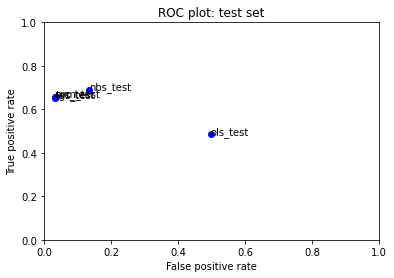

In [144]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [ ]:
# # read in test data for submission
# # CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
# raw_data, X_test_submission = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_test.csv', my_random_seed=74, test=True)
# print("Number of rows in the submission test set (should be 153,164): ")

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# # store the id from the raw data
# my_submission = pd.DataFrame(raw_data["id"])
# # concatenate predictions to the id
# my_submission["prediction"] = ols.predict(X_test_submission)
# # look at the proportion of positive predictions
# print(my_submission['prediction'].mean())

In [ ]:
# raw_data.head()

In [ ]:
# my_submission.head()

In [ ]:
# my_submission.shape

In [ ]:
# # export submission file as pdf
# # CHANGE FILE PATH: 
# my_submission.to_csv('/Users/Charles/Desktop/ML/A1/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation